# Lab:  Low-Rank Approximation for Movie Recommendations

A common application of low-rank approximation is for recommender systems.  In this lab, we will create a very primitive recommendation system for movies.  Through the lab, you will learn to:

* Represent ratings data as a sparse matrix
* Evaluate the mean absolute error (MAE) using simple movie or user biases
* Create a low-rank model in Tensorflow for predicting the movie rating using `Embedding` layers
* Train the model and optimize the embedding dimension.
* Make predictions on new users.

## Loading the MovieLens Dataset

We first load some common packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

[GroupLens](https://grouplens.org/) is a research organization at the University of Minnesota that has done extensive work in recommendation systems among other topics.  They have excellent datasets on movie recommendations as part of their [MovieLens project](https://movielens.org/).  In this lab, we will use a relatively small dataset, `Movielens 1m` that has 1 million ratings.  If you are interested in continuing research in this area, they have much larger datasets as well.  But, this relatively small one is sufficient to illustrate the basic concepts.

To get the data, go to the webpage:

https://grouplens.org/datasets/movielens/latest/

and download and unzip the files, `ml-1m.zip`.  Alternatively, you can just run the following command which will download unzip the file for you.

In [2]:
import tqdm
import requests
import os
import zipfile

# Set the files names for movies and ratings files
ml_dir = 'ml-1m'
ratings_fn = os.path.join(ml_dir,'ratings.dat')
movies_fn = os.path.join(ml_dir,'movies.dat')

def download_file(src_url, dst_fn):
    
    if os.path.exists(dst_fn):
        print('File %s already exists' % dst_fn)
        return
    
    print('Downloading %s' % dst_fn)
    
    # Streaming, so we can iterate over the response.
    r = requests.get(src_url, stream=True)

    # Total size in MB.
    total_size = int(r.headers.get('content-length', 0)); 
    block_size = 1024
    wrote = 0 
    with open(dst_fn, 'wb') as f:
        with tqdm.tqdm_notebook(total=total_size//block_size, unit='kB', 
                           unit_scale=True, unit_divisor=1024) as pbar:
            for data in r.iter_content(block_size):
                wrote = wrote + len(data)
                pbar.update(1)
                f.write(data)
    if total_size != 0 and wrote != total_size:
        print("ERROR, something went wrong") 

# Test if all files are downloaded
files_exists = False
if os.path.exists(ml_dir):
    if os.path.exists(ratings_fn) and os.path.exists(movies_fn):
        files_exists = True

if files_exists:
    print('Files %s and %s already downloaded' % (ratings_fn, movies_fn))

else:
    # First download the zip file if needed
    src_url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
    dst_fn = 'ml-1m.zip'
    download_file(src_url, dst_fn)
    
    # Then, unzip the file
    print('Unzipping %s...' % dst_fn)
    zip_ref = zipfile.ZipFile(dst_fn, 'r')
    zip_ref.extractall('.')
    zip_ref.close()
    print('Unzip completed')

Files ml-1m\ratings.dat and ml-1m\movies.dat already downloaded


Read the movies files with the `read_csv` command.  Print the first 5 entries of the dataframe.  You will see that the file has a list of movies.  Each movie has a `movieId` and `title`.

In [3]:
# TODO:  Read the movies 
import os
movies = pd.read_csv(movies_fn, sep='::', engine='python', encoding='latin-1',\
                    names=['movieId','title','genre'])

# TODO:  Use the movies.head() to display the first 5 entries
movies.head()

movieId                               title                         genre
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy

Extract the following columns from the `movies` dataframe:
*  Extract the `movieId` column, convert to an `np.array` and store in `movie_ids`
*  Extract the `title` column, convert to a list (using `.tolist()`) and store in `titles`

In [4]:
# TODO:
# movie_id = ...
# titles = ...
movie_ids = np.array(movies['movieId'],dtype=int)
titles = movies['title'].tolist()

The following function returns the string of a movie title, given its movie id.

In [5]:
def get_movie_title(movie_id):
    I = np.where(movie_ids == movie_id)[0]
    if len(I) == 0:
        return 'unknown'
    else:
        return titles[I[0]]

Load the `ratings.dat` file into a `pandas` dataframe `ratings`.  Use the `head` method to print the first five rows of the dataframe.  This is a large file, so it may take a minute to read in.

In [6]:
# TODO
# ratings = ...
#ratings = pd.read_csv(...)
ratings = pd.read_csv(ratings_fn, sep='::', engine='python', encoding='latin-1',
                     names=['userId','movieId','rating','timestamp'])
ratings.head()

userId  movieId  rating  timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291

Extract three columns from the `ratings` dataframe:

* Set `user` to `ratings['userId']`,
* Set `movie` to `ratings['movieId']`
* Set `y` to `ratings['rating']`

Convert to each to an `np.array`.  Print:

* Total number of movies (the maximum movie index)
* Total number of users
* Total number of ratings
* The average fraction of movies rated per user

You should see that only a small fraction of the movies are rated by each user.

In [7]:
user  = np.array(ratings['userId'])
movie = np.array(ratings['movieId'])
y = np.array(ratings['rating'])

#movie_ind0, movie = np.unique(movie0, return_inverse=True)

nuser = np.max(user)+1
nmovie = np.max(movie)+1
nsamp = movie.shape[0]
print('Number of movies = %d' % nmovie)
print('Number of users  = %d' % nuser)
print('Number of samples = %d' % nsamp)
print('Fraction rated = %12.4e' % (nsamp/nmovie/nuser))

Number of movies = 3953
Number of users  = 6041
Number of samples = 1000209
Fraction rated =   4.1885e-02


Our goal will be to predict the rating `y` from the indices `movie` and `user`.  We need to split the data into training and test.
Create training and test data of the form:

* Training data:  `Xtr = [usertr, movietr]` and `ytr` for approximately 75% of the samples.
* Test data:  `Xts = [userts, moviets]` and `yts` for approximately 25% of the samples.

In [9]:
# TODO
#   Xtr, ytr = ...
#   Xts, yts = ...
ntr = int(nsamp * 0.75)
I = np.random.permutation(nsamp)
Xtr = [user[I[:ntr]], movie[I[:ntr]] ]
Xts = [user[I[ntr:]], movie[I[ntr:]] ]
ytr = y[I[:ntr]]
yts = y[I[ntr:]]

## Simple Rating Prediction Based on Average Rating

Before we try to perform a complex algorithm for predicting a movie rating, we will first compute some simple statistics to get you familar with the data set.  First, compute the average movie rating across all movies in the training data set.

In [11]:
# TODO
y0 = np.mean(ytr)
print('Avg rating = %7.2f' % y0)

Avg rating =    3.58


Next, find the average rating per movie id. For each movie id, `i` compute `ymean[i]`, the average rating for that movie in the training data set and `ycnt[i]`, the number of ratings the movie had.  If `ycnt[i]==0`, set `ymean[i]=y0`, where `y0` is the average overall rating. 

You will want to think about how you do this computation efficiently since the data set `ytr` has a large number of entries.  Make you sure you go over the entries in `ytr` only once.  Even if you do it efficiently, it will take a minute, so you may want to add a progress bar.

In [13]:
# TODO
# ymean = ...
ycnt = np.zeros(nmovie)
usertr, movietr = Xtr
ymean = np.tile(y0, nmovie)

ntr = len(ytr)
with tqdm.tqdm(total=ntr) as pbar: 
    for m, r in zip(movietr, ytr):
        ycnt[m] += 1
        ymean[m] = 1/ycnt[m]*r + (1-1/ycnt[m])*ymean[m]
        pbar.update(1)

100%|██████████████████████████████████████████████████████████████████████| 750156/750156 [00:02<00:00, 276586.49it/s]


Print all the movies that had an average rating over 4.8.  Print their titles, the average rating and the number of ratings they had.  You will see that most of the movies with very high ratings had very few ratings.

In [15]:
# TODO
I = np.where(ymean >= 4.8)[0]
for i in I:
    print('%40s rating=%5.2f cnt=%5d ' % (get_movie_title(i), ymean[i], ycnt[i]))

                         Lamerica (1994) rating= 4.83 cnt=    6 
                   Dangerous Game (1993) rating= 5.00 cnt=    1 
                  Foreign Student (1994) rating= 5.00 cnt=    1 
      Gate of Heavenly Peace, The (1995) rating= 5.00 cnt=    3 
                 Follow the Bitch (1998) rating= 5.00 cnt=    1 
   Dry Cleaning (Nettoyage à sec) (1997) rating= 5.00 cnt=    1 
                 Ulysses (Ulisse) (1954) rating= 5.00 cnt=    1 
                    Smashing Time (1967) rating= 5.00 cnt=    1 
     I Am Cuba (Soy Cuba/Ya Kuba) (1964) rating= 4.80 cnt=    5 
                        Baby, The (1973) rating= 5.00 cnt=    1 
               Gay Deceivers, The (1969) rating= 5.00 cnt=    1 
                One Little Indian (1973) rating= 5.00 cnt=    1 
                            Lured (1947) rating= 5.00 cnt=    1 
                     Sunset Strip (2000) rating= 5.00 cnt=    2 
                Bittersweet Motel (2000) rating= 5.00 cnt=    1 


Now, for each `i` in the test data set, compute `yhat[i]` to be the mean rating for the movie in rating `i`.  Find the average value `|yhat[i]-yts[i]|`.  This is called the *mean absolute error* or MAE and is a common metric in evaluating recommendation predictions.  If you did everything correctly, you should get an MAE ~= 0.78.  That means that simply using the average movie rating by users will predict the rating of another user within 0.78 on average.

In [16]:
# TODO
#   yhat = ...
#   mae = ...
userts, moviets = Xts
yhat = ymean[moviets]
mae = np.mean(np.abs(yhat - yts))
print('MAE = %12.4e' % mae)

MAE =   7.8151e-01


## Building a Neural Network Recommender
We now build a neural network for predicting the ratings.  First, we load the necessary packages.

In [18]:
import tensorflow as tf

from tensorflow.keras.layers import Input, Embedding, Dot, Reshape, Dense, Flatten, Add, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

We can now create a neural network in Tensorflow as follows:

*  Set the embedding dimension to `emb_dim=4`.  
*  Let `userid_in` and `movieid_in` be the input user and movie indices.  These can be created in Tensorflow with `Input` layers with `shape = (1,)`. 
*  The user index generates a bias `user_bias`.  Use an `Embedding` layer with `output_dim=1` followed by a `Flatten` layer.  
*  The user index also generates a weight `user_wt`.  Use a second `Embedding` layer with `output_dim=emb_dim` followed by a `Flatten` layer.  
*  The movie index generates biases `movie_bias` and `movie_wt` similar to the user bias.
*  We then make the rating prediction with `yhat = Dot(user_wt, movie_wt) + user_bias + movie_bias`. 
*  Optionally, you can add bias and weight regularization, although I found these did not help significantly.
*  Set the model to `mod = Model([userid_in, movieid_in], yhat)`.

Print a summary of the model `mod.summary()`. 


In [36]:
# TODO:
#    mod = ...
#    mod.summary()

def create_mod(emb_dim, nuser, nmovie, bias_reg=0.0, wt_reg=0.0):

    userid_in = Input(name='user', shape=(1,))
    movieid_in = Input(name='movie', shape=(1,))
    user_bias0 = Embedding(input_dim=nuser, output_dim=1,name='user_bias0',
                          embeddings_regularizer=regularizers.l2(bias_reg))(userid_in)
    user_bias = Flatten(name='user_bias')(user_bias0)
    movie_bias0 = Embedding(input_dim=nmovie, output_dim=1,name='movie_bias0',
                           embeddings_regularizer=regularizers.l2(bias_reg))(movieid_in)
    movie_bias = Flatten(name='movie_bias')(movie_bias0)        

    if emb_dim > 0:
        user_wt0 = Embedding(input_dim=nuser, output_dim=emb_dim,name='user_wt0',
                            embeddings_regularizer=regularizers.l2(wt_reg))(userid_in)
        user_wt = Flatten(name='user_wt')(user_wt0)
        movie_wt0 = Embedding(input_dim=nmovie, output_dim=emb_dim,name='movie_wt0',
                             embeddings_regularizer=regularizers.l2(wt_reg))(movieid_in)
        movie_wt = Flatten(name='movie_wt')(movie_wt0)
        yhat0 = Dot(name='product',axes=1)([user_wt, movie_wt])
        yhat1  = Add(name='yhat1')([yhat0, movie_bias])
        yhat  = Add(name='yhat')([yhat1, user_bias])
    else:
        yhat  = Add(name='yhat')([movie_bias, user_bias])

    mod = Model([userid_in, movieid_in], yhat)
    return mod

K.clear_session()
mod = create_mod(emb_dim=4, nuser=nuser, nmovie=nmovie)
mod.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_wt0 (Embedding)            (None, 1, 4)         24164       user[0][0]                       
__________________________________________________________________________________________________
movie_wt0 (Embedding)           (None, 1, 4)         15812       movie[0][0]                      
_______________________________________________________________________________________

Compile the model with `Adam` optimizer with a learning rate of `0.01` (I found these numbers to work out well).  Use the 
`'mean_absolute_error'` loss.  Then fit the model with 8 epochs.  Use a batch size of 1000.  

In [37]:
# TODO
#    opt = ...
#    mod.compile(...)
#    mod.fit(...)
opt = Adam(lr=0.01)
mod.compile(optimizer=opt, loss='mean_absolute_error')
hist = mod.fit(Xtr,ytr,epochs=8,batch_size=1000, validation_data=(Xts,yts),\
              verbose=1)

Epoch 1/8


C:\Users\sdran\anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


751/751 [==============================] - 1s 1ms/step - loss: 1.1399 - val_loss: 0.7454
Epoch 2/8
751/751 [==============================] - 1s 1ms/step - loss: 0.7367 - val_loss: 0.7344
Epoch 3/8
751/751 [==============================] - 1s 1ms/step - loss: 0.7225 - val_loss: 0.7247
Epoch 4/8
751/751 [==============================] - 1s 1ms/step - loss: 0.7061 - val_loss: 0.7132
Epoch 5/8
751/751 [==============================] - 1s 1ms/step - loss: 0.6934 - val_loss: 0.7092
Epoch 6/8
751/751 [==============================] - 1s 1ms/step - loss: 0.6860 - val_loss: 0.7045
Epoch 7/8
751/751 [==============================] - 1s 1ms/step - loss: 0.6813 - val_loss: 0.7031
Epoch 8/8
751/751 [==============================] - 1s 1ms/step - loss: 0.6776 - val_loss: 0.7029


Print the training and test loss as a function of the epochs.  If you did it correctly the final test loss should be around  0.71 and the training loss should be 0.68.  This is a little better than the MAE you get just using the average movie rating.

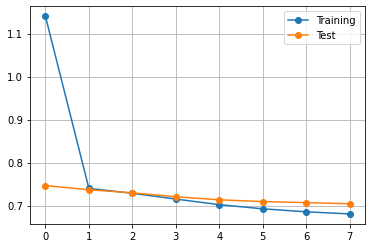

In [31]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
plt.plot(loss, 'o-')
plt.plot(val_loss,'o-')
plt.grid()
plt.legend(['Training', 'Test'])

    

## Making Predictions!

Select a random user, `user_id`.  Then, for each movie index, use the model to predict the ratings. Set the predictions to `yhat`.

In [75]:
# TODO
#    user_id = ...
#    yhat = ...
user_id = np.random.randint(0,nuser,1)
movie_in = np.arange(nmovie)[:,None]
user_in = np.tile(user_id, (nmovie,1))

yhat = mod.predict([user_in, movie_in])

Print the names of the movies with the top 10 predicted ratings for the user as well as the average rating that those movies had.  You will see that the network may predict ratings above 5!  We could have avoided this by limiting the output.

In [77]:
# TODO
yhat = yhat.ravel()
I = np.flipud(np.argsort(yhat))
n = 10
for i in range(n):
    j = I[i]
    movie_title = get_movie_title(j)    
    print('%-50s %5.2f %5.2f' % (movie_title, yhat[j], ymean[j]) )
    
    

Confessional, The (Le Confessionnal) (1995)         5.24  2.67
Schindler's List (1993)                             5.07  4.51
Ulysses (Ulisse) (1954)                             4.99  5.00
Man of the Century (1999)                           4.99  4.00
Talk of Angels (1998)                               4.96  4.00
Shawshank Redemption, The (1994)                    4.92  4.55
Walk in the Sun, A (1945)                           4.91  4.25
Godfather, The (1972)                               4.90  4.53
Casablanca (1942)                                   4.88  4.43
Chushingura (1962)                                  4.87  4.00


## Bonus:  Optimizing the Embedding Dimension

You can try to optimize the embedding dimension.  Try different dimensions from 0 to 8.  

In [78]:
# TODO
emb_dim_test = np.arange(8)
ntest = len(emb_dim_test)
nepochs1 = 10
nepochs0 = 10
nepochs = nepochs0*nepochs1

nepochs = 10

hist_tot = []
val_loss = np.zeros(ntest)
loss = np.zeros(ntest)

for itest, emb_dim in enumerate(emb_dim_test):
            
    K.clear_session()
    mod = create_mod(emb_dim=emb_dim, nuser=nuser, nmovie=nmovie)    
    opt = Adam(lr=0.01)
    mod.compile(optimizer=opt, loss='mean_absolute_error')
    
    hist = mod.fit(Xtr,ytr,epochs=nepochs,batch_size=1000, verbose=0, validation_data=(Xts,yts))
    hist_tot.append(hist.history)
    
    val_loss[itest] = hist.history['val_loss'][-1]
    loss[itest]     = hist.history['loss'][-1]
    print('Dim=%d loss=%12.4e val_loss=%12.4e' % (emb_dim, loss[itest], val_loss[itest]) )

C:\Users\sdran\anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Dim=0 loss=  7.1251e-01 val_loss=  7.1689e-01
Dim=1 loss=  7.0006e-01 val_loss=  7.0785e-01
Dim=2 loss=  6.9037e-01 val_loss=  7.0488e-01
Dim=3 loss=  6.7931e-01 val_loss=  7.0187e-01
Dim=4 loss=  6.7226e-01 val_loss=  7.0201e-01
Dim=5 loss=  6.6419e-01 val_loss=  7.0097e-01
Dim=6 loss=  6.6025e-01 val_loss=  7.0228e-01
Dim=7 loss=  6.5500e-01 val_loss=  7.0538e-01


Plot the training and test loss as a function of the embedding layer. We see we get a minimum with an embedding dimension around 4 or 5.

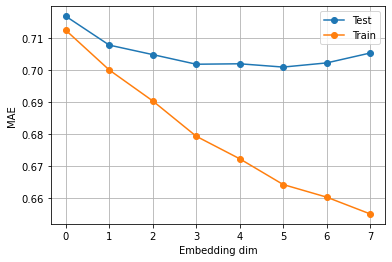

In [79]:
plt.plot(emb_dim_test, val_loss, 'o-')
plt.plot(emb_dim_test, loss, 'o-')
plt.grid()
plt.ylabel('MAE')
plt.xlabel('Embedding dim')
plt.legend(['Test', 'Train'])

